In [1]:
import numpy as np

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

# LiH
geometry = [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.75))]
basis = "6-31g"
spin = 0
charge = 0

"""Other examples:

# H2
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))]
basis = "sto-3g"
spin = 0  # = 2 S with S total spin angular momentum = # of unpaired electrons
charge = 0

# CO2
geometry = [['C', [0.0, 0.0, 8.261342997000753e-07]],
            ['O', [1.0990287608769004e-18, 2.7114450405987004e-19, 1.2236575813458745]],
            ['O', [2.696319376811295e-22, 2.4247676462727696e-23, -1.2236561920609494]]]
basis = "sto-3g"
spin = 1
charge = 1
"""

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, verbose=True)

# rdm1 = (rdm1[0] + rdm1[1]) / 2. # For CO2
print("Number of qubits before active space selection = ", rdm1.shape[0] * 2)

/usr/local/lib64/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


HF energy= -7.978244325721484
MP2 energy= -7.9912716321532455
FCI energy= -7.998354311186436
Number of qubits before active space selection =  22


In [2]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo

# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

print(mol_h)

 MolecularHamiltonian(
 - constant_coeff : 0.9071609330057144
 - integrals shape
    * one_body_integrals : (11, 11)
    * two_body_integrals : (11, 11, 11, 11)



In [3]:
from qat.fermion.chemistry import transform_integrals_to_new_basis

# Compute the natural orbitals occupation numbers and the basis transformation matrix
noons, basis_change = np.linalg.eigh(rdm1)

# The noons should be in decreasing order
noons = list(reversed(noons))

# Since we reversed the noons, we have to flip the basis as well
basis_change = np.flip(basis_change, axis=1)

In [7]:
molecule = MoleculeInfo(
    mol_h,
    n_electrons=n_electrons,
    noons=noons,
    orbital_energies=orbital_energies,
)

In [8]:
molecule.hamiltonian = molecule.hamiltonian.transform_basis(basis_change)

In [9]:
molecule

MoleculeInfo(
 - MolecularHamiltonian(
    * constant_coeff : 0.9071609330057144
    * integrals shape
       ** one_body_integrals : (11, 11)
       ** two_body_integrals : (11, 11, 11, 11)
 - n_electrons = 4
 - noons = [1.9999088035754364, 1.9490174406349356, 0.04680924231304321, 0.0018388293339856952, 0.0009388057229616656, 0.000938805722961665, 0.0004987405822802961, 2.531545350653864e-05, 1.160143895502515e-05, 1.1601438955024442e-05, 8.137829787419237e-07]
 - orbital energies = [-2.46481078 -0.29198191  0.00584726  0.05830485  0.05830485  0.14705508
  0.19900943  0.21877097  0.21877097  0.32774881  1.30468514]
)

In [10]:
# Selection of the active space
molecule.restrict_active_space(threshold_1=0.02, threshold_2=0.002)

In [11]:
molecule

MoleculeInfo(
 - MolecularHamiltonian(
    * constant_coeff : 0.9071609330057144
    * integrals shape
       ** one_body_integrals : (2, 2)
       ** two_body_integrals : (2, 2, 2, 2)
 - n_electrons = 2
 - noons = [1.9490174406349356, 0.04680924231304321]
 - orbital energies = [-0.2919819062330889, 0.005847259432343252]
)

In [13]:
from qat.fermion.chemistry.ucc import *

# Alternatively, one can use the .apply method to select automatically the right attributes in the MoleculeInfo class.
theta_list = molecule.apply(guess_init_params)
ket_hf_init = molecule.apply(get_hf_ket)
cluster_ops = molecule.apply(get_cluster_ops)

In [14]:
from qat.fermion.transforms import transform_to_jw_basis

# Compute the ElectronicStructureHamiltonian
H_active = molecule.hamiltonian.get_electronic_hamiltonian()

# Transform the ElectronicStructureHamiltonian into a spin Hamiltonian
H_active_sp = transform_to_jw_basis(H_active)

print(H_active_sp.htype)

ObservableType.SPIN


In [15]:
from qat.fermion.transforms import recode_integer, get_jw_code

# Express the cluster operator in spin terms
cluster_ops_sp = [transform_to_jw_basis(t_o) for t_o in cluster_ops]

# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, get_jw_code(H_active_sp.nbqbits))

In [60]:
from qat.lang.AQASM import Program, X
from qat.fermion.trotterisation import make_trotterisation_routine

nqbits = cluster_ops_sp[0].nbqbits

prog = Program()
reg = prog.qalloc(nqbits)

# Initialize the Hartree-Fock state into the Program
for j, char in enumerate(format(hf_init_sp, "0" + str(nqbits) + "b")):
    if char == "1":
        prog.apply(X, reg[j])

# Define the parameters to optimize
theta = [prog.new_var(float, "\\theta_{%s}" % i) for i in range(len(cluster_ops))]

# Define the parameterized Hamiltonian
hamiltonian = sum([th * T for th, T in zip(theta, cluster_ops_sp)])

In [61]:
obs = hamiltonian.terms[0]

#### Spin hamiltonian trotter slice

In [66]:
from qat.lang.AQASM import *
from qat.core.variables import real

coeff = 1.0


def _one_operator_circuit(op, qbits):
    r"""Construct cascade of CNOTs corresponds to Pauli string

    Args:
        op (str): string with X,Y,Z,I
        qbits (list<int>): list of bits on which they are applied

    Returns:
        QRoutine, qb: the routine and the index of last qbit
    """
    nqbits = len(qbits)
    _qbits = range(nqbits)
    Qrout = QRoutine()
    for qb, pauli in zip(_qbits, op):
        if pauli == "X":
            Qrout.apply(H, qb)
        if pauli == "Y":
            Qrout.apply(RX(np.pi / 2), qb)

    previous_qb = nqbits - 1
    for qb, pauli in zip(_qbits[::-1][1:], op[::-1][1:]):
        if pauli != "I":
            Qrout.apply(CNOT, previous_qb, qb)
            previous_qb = qb
    return Qrout, qbits[previous_qb]


Qrout = QRoutine()

term = obs
Qrout_one, ref = _one_operator_circuit(term.op, term.qbits)
if Qrout_one.arity != 0:
    Qrout.apply(Qrout_one, term.qbits)
Qrout.apply(RZ(2 * coeff * real(term.coeff)), ref)
if Qrout_one.arity != 0:
    Qrout.apply(Qrout_one.dag(), term.qbits)

In [68]:
prog = Program()
reg = prog.qalloc(4)

In [69]:
prog.apply(Qrout, reg)

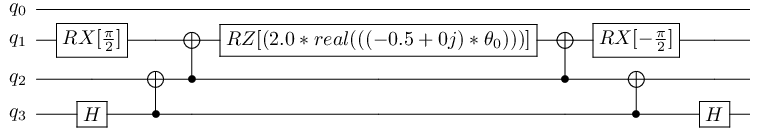

In [70]:
prog.to_circ().display()

#### phase estimation - rk routine

In [71]:
th = theta[0]

In [75]:
ops = "X"
qbits = list(range(4))
th = theta[0]

qrout = QRoutine()
qbits = qrout.new_wires(4)
with qrout.compute():
    for op, qbit in zip(ops, qbits):
        if op == "X":
            qrout.apply(H, qbit)
        if op == "Y":
            qrout.apply(RX(np.pi / 2), qbit)
    for ind_qb in range(len(qbits) - 1):
        qrout.apply(CNOT, qbits[ind_qb], qbits[ind_qb + 1])
qrout.apply(RZ(th), qbits[-1])
qrout.uncompute()  # uncompute() applies U^dagger,
# with U the unitary corresponding to the gates applied within the "with XX.compute()" context

In [77]:
prog = Program()
reg = prog.qalloc(4)

prog.apply(qrout, reg)

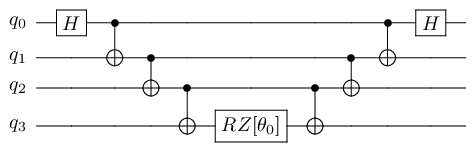

In [78]:
prog.to_circ().display()

#### one operator circuit

In [85]:
op = obs.op

nqbits = len(qbits)
_qbits = range(nqbits)
Qrout = QRoutine()

for qb, pauli in zip(_qbits, op):
    if pauli == "X":
        Qrout.apply(H, qb)
    if pauli == "Y":
        Qrout.apply(RX(np.pi / 2), qb)

previous_qb = nqbits - 1
for qb, pauli in zip(_qbits[::-1][1:], op[::-1][1:]):
    if pauli != "I":
        Qrout.apply(CNOT, previous_qb, qb)
        previous_qb = qb